# 제품 이상여부 판별 프로젝트

## 1. 데이터 불러오기

### 필수 라이브러리


In [1]:
def process_workorder(df):
    # 모든 문자열 열을 문자열로 변환하고 결측값을 'NaN'으로 채우기
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).fillna('NaN')

    # 각 칼럼에 전처리 함수 적용
    df['Workorder_Fill1'] = df['Workorder_Fill1'].apply(tailing_zero_remover)
    df['Workorder_Fill2'] = df['Workorder_Fill2'].apply(tailing_zero_remover)
    df['Workorder_Dam'] = df['Workorder_Dam'].apply(tailing_zero_remover)
    df['Workorder_AutoClave'] = df['Workorder_AutoClave'].apply(tailing_zero_remover)

    # 전처리 후 각 칼럼에 동일한 문자열 추출 작업 적용
    df['Workorder_Fill1_1'] = df['Workorder_Fill1'].str[0:2]  # 0번째와 1번째 문자
    df['Workorder_Fill1_2'] = df['Workorder_Fill1'].str[2:4]    # 2번째와 3번째 문자
    df['Workorder_Fill1_3'] = df['Workorder_Fill1'].str[9:10] # 9번째 문자

    df['Workorder_Fill2_1'] = df['Workorder_Fill2'].str[0:2]  # 0번째와 1번째 문자
    df['Workorder_Fill2_2'] = df['Workorder_Fill2'].str[2:4]    # 2번째와 3번째 문자
    df['Workorder_Fill2_3'] = df['Workorder_Fill2'].str[9:10] # 9번째 문자

    df['Workorder_Dam_1'] = df['Workorder_Dam'].str[0:2]    # 0번째와 1번째 문자
    df['Workorder_Dam_2'] = df['Workorder_Dam'].str[2:4]      # 2번째와 3번째 문자
    df['Workorder_Dam_3'] = df['Workorder_Dam'].str[9:10]   # 9번째 문자

    df['Workorder_AutoClave_1'] = df['Workorder_AutoClave'].str[0:2]  # 0번째와 1번째 문자
    df['Workorder_AutoClave_2'] = df['Workorder_AutoClave'].str[2:4]    # 2번째와 3번째 문자
    df['Workorder_AutoClave_3'] = df['Workorder_AutoClave'].str[9:10] # 9번째 문자

    # 기존 칼럼 삭제
    df.drop(columns=['Workorder_Fill1', 'Workorder_Fill2', 'Workorder_Dam', 'Workorder_AutoClave'], inplace=True)

    # 새로 생성된 칼럼들을 categorical 타입으로 변환
    categorical_cols = [
        'Workorder_Fill1_1', 'Workorder_Fill1_2', 'Workorder_Fill1_3',
        'Workorder_Fill2_1', 'Workorder_Fill2_2', 'Workorder_Fill2_3',
        'Workorder_Dam_1', 'Workorder_Dam_2', 'Workorder_Dam_3',
        'Workorder_AutoClave_1', 'Workorder_AutoClave_2', 'Workorder_AutoClave_3'
    ]

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('object')  # 먼저 'object' 타입으로 변환

    # 결측값 처리
    df = df.fillna('NaN')

    # 이제 'object' 타입 열을 'category' 타입으로 변환
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    return df

In [2]:
# 문자열 전처리 함수 정의
def tailing_zero_remover(input_string):
    # 문자열을 '-'로 분리
    parts = input_string.split('-')

    # '-'로 분리된 두 번째 부분을 정수로 변환하여 앞의 0을 제거
    parts[1] = str(int(parts[1]))

    # 다시 합쳐서 반환
    return '-'.join(parts)

In [3]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기

In [4]:
# ROOT_DIR = "data"
ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/"
RANDOM_STATE = 110

In [5]:
# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

train_data.info()

train_data.describe()

train_data["target"].value_counts()

test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 464 entries, Wip Line_Dam to target
dtypes: float64(350), int64(77), object(37)
memory usage: 143.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 465 entries, Set ID to target
dtypes: float64(351), int64(77), object(37)
memory usage: 61.6+ MB


In [6]:
# 'tt' 칼럼 추가
train_data['tt'] = 'train'
test_data['tt'] = 'test'

train_target = train_data['target']
test_id = test_data['Set ID']
test_target = test_data['target']

test_data = test_data.drop(columns=['Set ID', 'target'])

train_data = train_data.drop(columns = ['target'])

integ_df = pd.concat([train_data, test_data], ignore_index=True)

integ_df.describe()

integ_df.isnull().sum()

,0
Wip Line_Dam,0
Process Desc._Dam,0
Equipment_Dam,0
Model.Suffix_Dam,0
Workorder_Dam,0
...,...
Receip No Judge Value_Fill2,57867
WorkMode Collect Result_Fill2,0
WorkMode Unit Time_Fill2,57867
WorkMode Judge Value_Fill2,57867


In [7]:
# 각 열별 결측치 개수 확인
missing_values_count = (integ_df.isnull().sum())
missing_values_count = missing_values_count/integ_df.shape[0]
missing_values_ratio = missing_values_count * 100
print(missing_values_ratio)

bins = [0, 20, 40, 60, 70, 80, 90,100]
missing_values_counts = pd.cut(missing_values_ratio, bins=bins).value_counts().sort_index()

print(missing_values_counts)

Wip Line_Dam                       0.0
Process Desc._Dam                  0.0
Equipment_Dam                      0.0
Model.Suffix_Dam                   0.0
Workorder_Dam                      0.0
                                 ...  
Receip No Judge Value_Fill2      100.0
WorkMode Collect Result_Fill2      0.0
WorkMode Unit Time_Fill2         100.0
WorkMode Judge Value_Fill2       100.0
tt                                 0.0
Length: 464, dtype: float64
(0, 20]        0
(20, 40]       3
(40, 60]       0
(60, 70]       0
(70, 80]       5
(80, 90]       0
(90, 100]    278
Name: count, dtype: int64


In [8]:
# 결측치 비율이 90 이상인 열 삭제
threshold = 90
integ_df= integ_df.drop(columns=missing_values_ratio[missing_values_ratio >= threshold].index)

In [9]:
integ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57867 entries, 0 to 57866
Columns: 186 entries, Wip Line_Dam to tt
dtypes: float64(72), int64(77), object(37)
memory usage: 82.1+ MB


In [10]:
# 1. 상수 열 식별
constant_columns = [col for col in integ_df.columns if integ_df[col].nunique() == 1]

# 2. 상수 열 개수와 이름 확인
print(f"Number of constant columns: {len(constant_columns)}")
print(f"Constant columns: {constant_columns}")

print(integ_df['Wip Line_Dam'])

# 3. 상수 열 삭제
integ_df.drop(columns=constant_columns, inplace=True)

# 4. 삭제된 열의 이름 반환
print(f"Deleted columns: {constant_columns}")

integ_df.info()

integ_df.shape

Number of constant columns: 40
Constant columns: ['Wip Line_Dam', 'Process Desc._Dam', 'Insp. Seq No._Dam', 'Insp Judge Code_Dam', 'CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION Θ Collect Result_Dam', 'CURE START POSITION Z Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam', 'Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave', 'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave', '1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave', '3rd Pressure Judge Value_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave', 'Wip Line_Fill1', 'Process Desc._Fill1', 'Insp. Seq No._Fill1', 'Insp Judge Code_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1', 'Wip Line_Fill2', 'Process Desc._Fill2', 'Insp. Seq No._Fill2', 'Insp Judge Code_Fill2', 'CURE END POSITION Θ Collect Result_Fill2'

(57867, 146)

In [11]:
# 숫자형 데이터만 선택
numeric_df = integ_df.select_dtypes(include=[float, int])

# 상관관계 계산
correlation_matrix = numeric_df.corr()

# 상관관계 행렬 출력
print(correlation_matrix)

                                          CURE END POSITION X Collect Result_Dam  \
CURE END POSITION X Collect Result_Dam                                  1.000000   
CURE END POSITION Z Collect Result_Dam                                  1.000000   
CURE END POSITION Θ Collect Result_Dam                                  1.000000   
CURE SPEED Collect Result_Dam                                           0.075891   
CURE START POSITION X Collect Result_Dam                               -1.000000   
...                                                                          ...   
Machine Tact time Collect Result_Fill2                                  0.267969   
PalletID Collect Result_Fill2                                           0.415403   
Production Qty Collect Result_Fill2                                    -0.166167   
Receip No Collect Result_Fill2                                          0.188893   
WorkMode Collect Result_Fill2                                           0.15

In [12]:
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# 상관계수가 0.9 이상인 피처 식별
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features  = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

print(f"Number of features with correlation higher than 0.9: {len(high_corr_features)}")
print(f"Features with high correlation: {high_corr_features}")

Number of features with correlation higher than 0.9: 85
Features with high correlation: ['CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'Head Clean Position Z Collect Result_Dam', 'Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Purge Position Z Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'Head Zero Position Y Collect Result_Dam', 'Head Zero Position Z Collect Result_Dam', 'Machine Tact time Collect Result_Dam', 'PalletID Collect Res

In [14]:
# 상관계수가 높은 피처 삭제
integ_df_reduced = integ_df.drop(columns=high_corr_features)
print(f"Deleted columns due to high correlation: {high_corr_features}")
integ_df_reduced.head()

Deleted columns due to high correlation: ['CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'Head Clean Position Z Collect Result_Dam', 'Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Purge Position Z Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'Head Zero Position Y Collect Result_Dam', 'Head Zero Position Z Collect Result_Dam', 'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam', 'Stage1 Circle1 Distance Speed Collec

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,...,Workorder_Fill2,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,CURE START POSITION X Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,WorkMode Collect Result_Fill2,tt
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,100,1030,16,14.9,8.4,1.04,...,4F1XA938-1,240,33,48,33,1020,NaN,835.5,1,train
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,70,1030,10,21.3,4.9,1.49,...,3KPM0016-2,240,33,50,33,1020,835.5,458.0,0,train
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,85,280,16,14.7,8.5,1.61,...,4E1X9167-1,240,33,50,33,1020,OK,305.0,1,train
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,70,280,10,21.3,8.4,1.49,...,3K1X0057-1,240,33,50,33,1020,305,499.8,0,train
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,70,1030,10,9.7,4.9,0.67,...,3HPM0007-1,240,32,50,33,1020,835.5,458.0,0,train


In [15]:
# 삭제할 컬럼의 리스트 확인
print(f"Columns to be deleted: {high_corr_features}")

# 삭제할 컬럼의 개수 확인
print(f"Number of columns to delete: {len(high_corr_features)}")

# df_reduced의 컬럼 개수 확인
print(f"Number of columns in df_reduced after deletion: {integ_df_reduced.shape[1]}")

# 삭제 후 컬럼 목록 확인
print(f"Columns remaining in df_reduced: {integ_df_reduced.columns.tolist()}")

Columns to be deleted: ['CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'Head Clean Position Z Collect Result_Dam', 'Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Purge Position Z Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'Head Zero Position Y Collect Result_Dam', 'Head Zero Position Z Collect Result_Dam', 'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam', 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'St

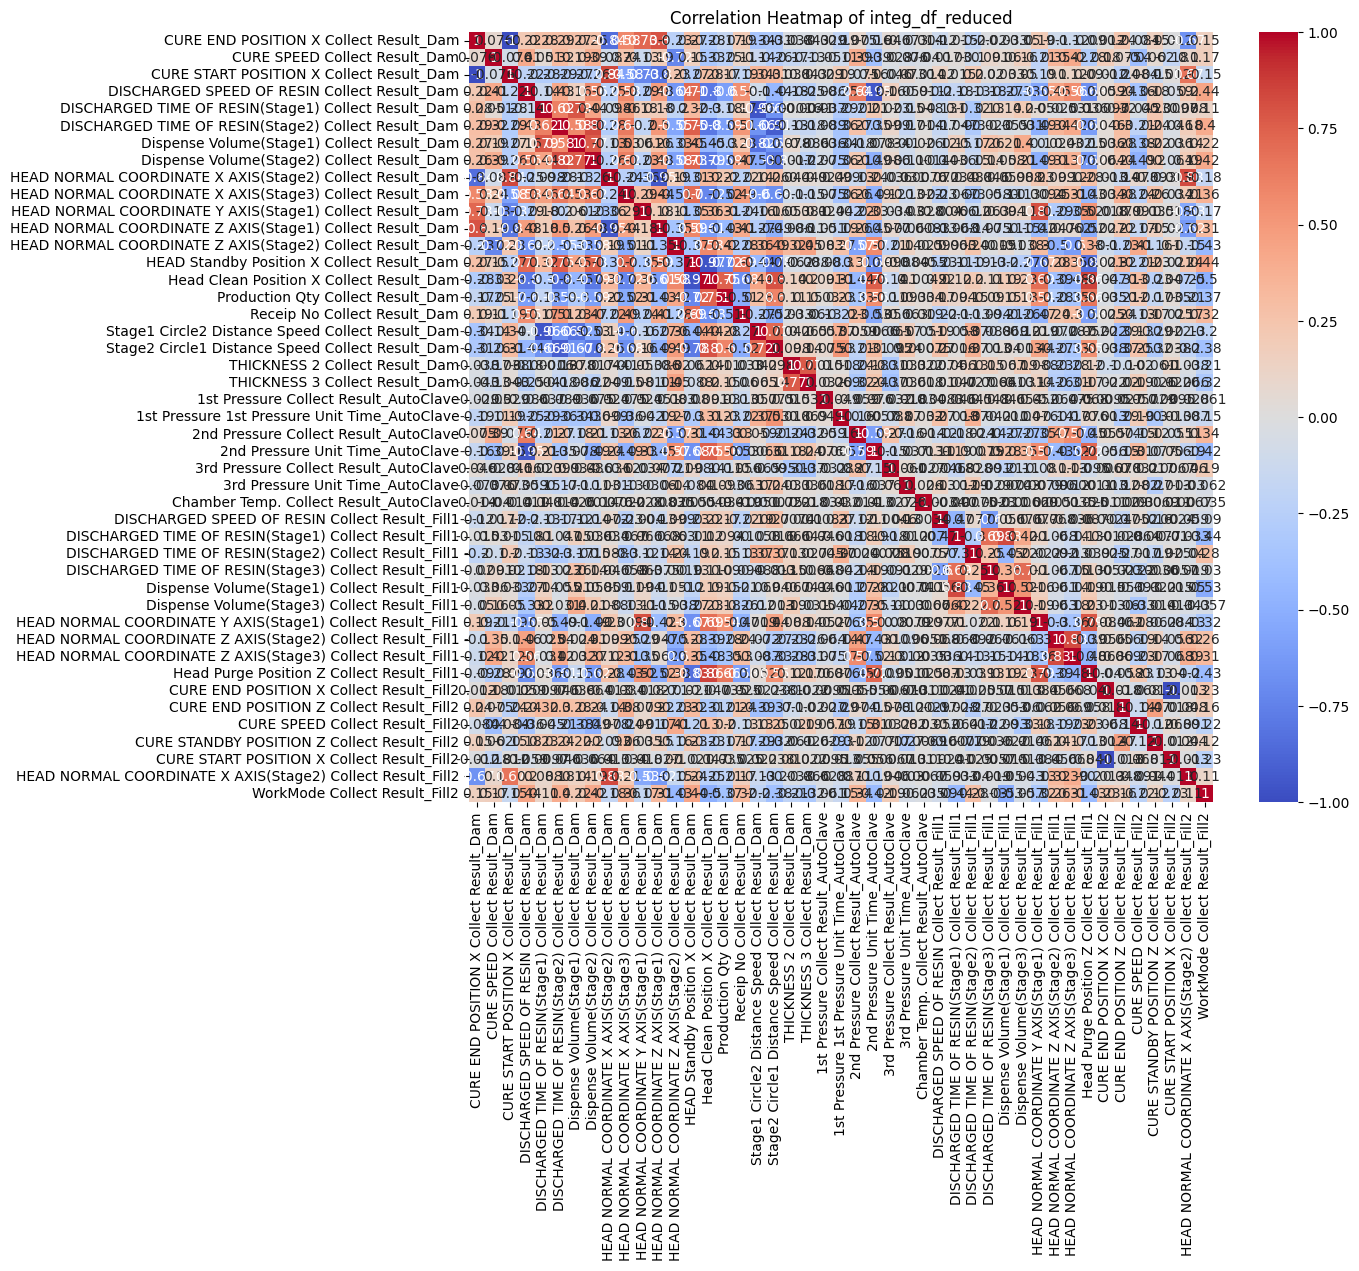

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df_reduced에서 숫자형 데이터만 선택하여 상관계수 행렬 계산
# 히트맵 생성
plt.figure(figsize=(12, 10))  # 히트맵 크기 설정
sns.heatmap(integ_df_reduced.select_dtypes(include=['float', 'int']).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of integ_df_reduced')
plt.show()

In [17]:
#스케일링 진행
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
numeric_df_scaled = scaler.fit_transform(numeric_df)

In [18]:
# 범주형 데이터 열 확인
categorical_columns = integ_df_reduced.select_dtypes(include=['object', 'category']).columns

# 범주형 데이터 열 개수 출력
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Categorical columns: {categorical_columns.tolist()}")

Number of categorical columns: 16
Categorical columns: ['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'Model.Suffix_AutoClave', 'Workorder_AutoClave', 'Chamber Temp. Judge Value_AutoClave', 'Equipment_Fill1', 'Model.Suffix_Fill1', 'Workorder_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'Equipment_Fill2', 'Model.Suffix_Fill2', 'Workorder_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2', 'tt']


In [19]:
# 범주형 열만 선택하여 새로운 DataFrame 생성
categorical_df = integ_df_reduced[['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
                     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                     'Model.Suffix_AutoClave', 'Workorder_AutoClave',
                     'Chamber Temp. Judge Value_AutoClave', 'Equipment_Fill1',
                     'Model.Suffix_Fill1', 'Workorder_Fill1',
                     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
                     'Equipment_Fill2', 'Model.Suffix_Fill2', 'Workorder_Fill2',
                     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']]

# 선택된 범주형 열의 데이터 출력
print(categorical_df.head())

# 각 범주형 열에서 고유 값의 개수와 고유 값 출력
for col in categorical_columns:
    num_unique_vals = len(integ_df_reduced[col].unique())  # 고유 값의 개수
    print(f"Column: {col}")
    print(f"Number of unique values: {num_unique_vals}")
    print(f"Unique values: {integ_df_reduced[col].unique()}\n")  # 고유 값 출력

      Equipment_Dam Model.Suffix_Dam Workorder_Dam  \
0  Dam dispenser #1      AJX75334505    4F1XA938-1   
1  Dam dispenser #1      AJX75334505    3KPM0016-2   
2  Dam dispenser #2      AJX75334501    4E1X9167-1   
3  Dam dispenser #2      AJX75334501    3K1X0057-1   
4  Dam dispenser #1      AJX75334501    3HPM0007-1   

  HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam  \
0                                                NaN         
1                                              550.3         
2                                                 OK         
3                                              162.4         
4                                                549         

  Model.Suffix_AutoClave Workorder_AutoClave  \
0            AJX75334505          4F1XA938-1   
1            AJX75334505          3KPM0016-2   
2            AJX75334501          4E1X9167-1   
3            AJX75334501          3K1X0057-1   
4            AJX75334501          3HPM0007-1   

  Chamber Tem

In [20]:
import pandas as pd

integ_df_reduced = process_workorder(integ_df_reduced) # 과적합 생기는 것 같아서 지워볼 예정
# integ_df_reduced.drop(columns=['Workorder_Fill1','Workorder_Fill2','Workorder_Dam','Workorder_AutoClave'], inplace=True)

# 'tt' 칼럼을 기준으로 train과 test로 다시 분리
train = integ_df_reduced[integ_df_reduced['tt'] == 'train'].copy()
test = integ_df_reduced[integ_df_reduced['tt'] == 'test'].copy()

# 'tt' 칼럼은 이제 필요 없으므로 삭제
train.drop(columns=['tt'], inplace=True)
test.drop(columns=['tt'], inplace=True)

# train 데이터에 원래 target 값 추가
train['target'] = train_target.values

# test 데이터에 NaN으로 채워진 target 칼럼 추가
test['target'] = float('nan')

# 결과 확인
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print(train.head())
print(test.head())

Train data shape: (40506, 69)
Test data shape: (17361, 69)
      Equipment_Dam Model.Suffix_Dam  CURE END POSITION X Collect Result_Dam  \
0  Dam dispenser #1      AJX75334505                                   240.0   
1  Dam dispenser #1      AJX75334505                                   240.0   
2  Dam dispenser #2      AJX75334501                                  1000.0   
3  Dam dispenser #2      AJX75334501                                  1000.0   
4  Dam dispenser #1      AJX75334501                                   240.0   

   CURE SPEED Collect Result_Dam  CURE START POSITION X Collect Result_Dam  \
0                            100                                      1030   
1                             70                                      1030   
2                             85                                       280   
3                             70                                       280   
4                             70                                      

In [21]:
normal_ratio = 3.0  # 1.0 means 1:1 ratio

df_normal = train[train["target"] == "Normal"]
df_abnormal = train[train["target"] == "AbNormal"]

print(f"  Total: Normal: {len(df_normal)}, AbNormal: {len(df_abnormal)}")

df_normal = df_normal.sample(n=int(len(df_abnormal) * normal_ratio), replace=False, random_state=RANDOM_STATE)

  Total: Normal: 38156, AbNormal: 2350


In [22]:
df_abnormal.loc[:, 'target'] = df_abnormal['target'].astype(str)
df_normal.loc[:, 'target'] = df_normal['target'].astype(str)

In [23]:
train_df = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
train_df.value_counts("target")

,count
target,
Normal,7050
AbNormal,2350


In [24]:
train_df['target']

,target
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
9395,AbNormal
9396,AbNormal
9397,AbNormal
9398,AbNormal


In [25]:
# 인코딩: 'Normal'을 1로, 'Abnormal'을 0으로 변환
mapping = {'Normal': 1, 'AbNormal': 0}
train_df['target'] = train_df['target'].map(mapping)

X = train_df.drop('target', axis=1)
y = train_df['target']

# for c in sorted(X.columns.tolist()):
#   print(c)

In [26]:
# train test 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.isnull().sum()

,0
Equipment_Dam,0
Model.Suffix_Dam,0
CURE END POSITION X Collect Result_Dam,0
CURE SPEED Collect Result_Dam,0
CURE START POSITION X Collect Result_Dam,0
...,...
Workorder_Dam_2,0
Workorder_Dam_3,0
Workorder_AutoClave_1,0
Workorder_AutoClave_2,0


In [27]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [28]:
# X_train.isna().sum().sum()
y_train

,target
462,1
4842,1
449,1
2167,1
8819,0
...,...
5734,1
5191,1
5390,1
860,1


In [29]:
# 모델 및 optuna 정의

from catboost import CatBoostClassifier
import optuna
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# 모든 범주형 열의 NaN 값을 'NaN' 문자열로 대체
def preprocess_data(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        df[col] = df[col].astype(str).fillna('NaN')

    return df

# 데이터 전처리
X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val)


# 범주형 변수 인덱스 찾기
categorical_features_indices = [
    i for i, col in enumerate(X_train.columns)
    if X_train[col].dtype.name in ['category', 'object']
]

# Optuna 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 탐색 공간
    iterations = trial.suggest_int('iterations', 500, 2000)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True)

    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        eval_metric='F1',
        random_seed=42,
        logging_level='Silent'
    )

    # 모델 학습
    model.fit(
        X_train,
        y_train,
        cat_features=categorical_features_indices,  # 범주형 열의 인덱스 전달
        eval_set=(X_val, y_val),
        early_stopping_rounds=100,
        verbose=False
    )

    # 모델 예측
    y_pred_encoded = model.predict(X_val)

    # F1 점수 반환
    return f1_score(y_val, y_pred_encoded)

# Optuna study 설정 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print(f"Best trial: {study.best_trial.params}")

# 최적의 하이퍼파라미터로 최종 모델 학습
best_params = study.best_trial.params
model = CatBoostClassifier(
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    eval_metric='F1',
    random_seed=42
)

model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_val, y_val),
    verbose=100,
    early_stopping_rounds=100
)

[I 2024-08-27 14:40:42,867] A new study created in memory with name: no-name-0b9b04c4-b30b-4638-a810-05b9c34a9932
[I 2024-08-27 14:40:52,973] Trial 0 finished with value: 0.8553921568627452 and parameters: {'iterations': 1535, 'learning_rate': 0.0044561750833863, 'depth': 8, 'l2_leaf_reg': 0.2757615449547944}. Best is trial 0 with value: 0.8553921568627452.
[I 2024-08-27 14:40:56,376] Trial 1 finished with value: 0.8551301684532924 and parameters: {'iterations': 1471, 'learning_rate': 0.01793344061482966, 'depth': 5, 'l2_leaf_reg': 4.421514675599027}. Best is trial 0 with value: 0.8553921568627452.
[I 2024-08-27 14:41:01,899] Trial 2 finished with value: 0.8550413729696599 and parameters: {'iterations': 1337, 'learning_rate': 0.008315086456021074, 'depth': 5, 'l2_leaf_reg': 1.4631146475223276}. Best is trial 0 with value: 0.8553921568627452.
[I 2024-08-27 14:41:19,369] Trial 3 finished with value: 0.8591767254719901 and parameters: {'iterations': 846, 'learning_rate': 0.232409853682409

Best trial: {'iterations': 948, 'learning_rate': 0.04092700316427656, 'depth': 5, 'l2_leaf_reg': 0.0031205100920282344}
0:	learn: 0.8584676	test: 0.8535616	best: 0.8535616 (0)	total: 36.9ms	remaining: 34.9s
100:	learn: 0.8658088	test: 0.8577586	best: 0.8577586 (92)	total: 3.23s	remaining: 27.1s
200:	learn: 0.8689167	test: 0.8601420	best: 0.8601420 (197)	total: 6.37s	remaining: 23.7s
300:	learn: 0.8715179	test: 0.8608615	best: 0.8614813 (291)	total: 12s	remaining: 25.7s
400:	learn: 0.8754945	test: 0.8616724	best: 0.8620261 (378)	total: 15.4s	remaining: 21.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8620261032
bestIteration = 378

Shrink model to first 379 iterations.


In [30]:
# 최종 모델로 예측
y_pred_encoded = model.predict(X_val)

In [31]:
# F1 점수 계산
f1 = f1_score(y_val, y_pred_encoded)
print(f"Final F1 score: {f1}")

Final F1 score: 0.8620261031696705


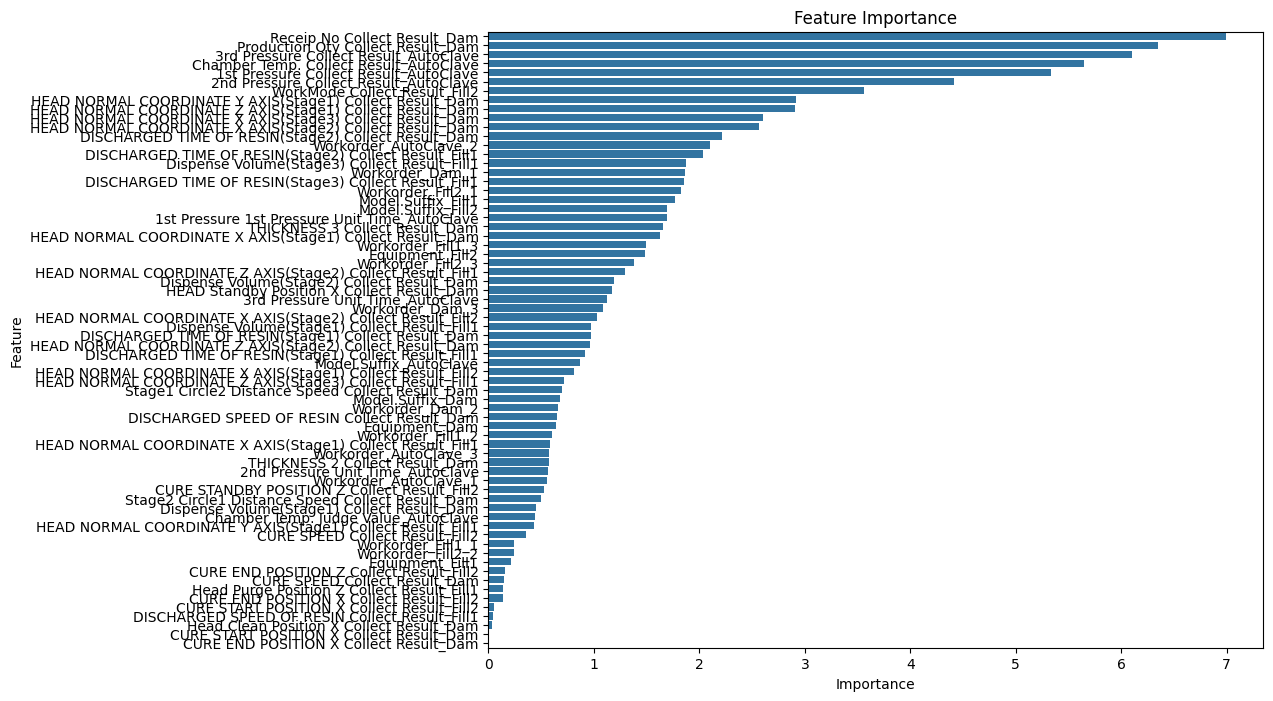

In [32]:
# 피처 중요도 시각화
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# 중요도를 데이터프레임으로 정리
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False) # 중요도 순으로 정렬

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.show()

In [33]:
# 모든 범주형 열의 NaN 값을 'NaN' 문자열로 대체 (X_test 포함)
# categorical_columns = test.select_dtypes(include=['object', 'category']).columns

# for col in categorical_columns:
#     test[col] = test[col].astype(str).fillna('NaN')

# exclude_columns = ['Workorder_first', 'Workorder_sec', 'Workorder_third']
# test['Workorder_third']

In [34]:
try:
  test.drop(columns=['target'], inplace=True)
except:
  print("target col not in test, good to go")

In [35]:
test = preprocess_data(test)

In [36]:
# 모델 예측
test_pred = model.predict(test)

In [37]:
test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [38]:
# 디코딩
mapping = {1: 'Normal', 0: 'AbNormal'}
test_pred = np.vectorize(mapping.get)(test_pred)

In [39]:
# submission 파일 호출
df_sub = pd.read_csv(os.path.join(ROOT_DIR, "submission.csv"))

df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv(os.path.join(ROOT_DIR, "submission.csv"), index=False)